In [358]:
import csv
from pathlib import Path
import pandas as pd 
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [232]:
PROJPATH = Path().resolve().parent
datapath = PROJPATH / "data/weatherstations/ACIS/stationdata/low_missing"
rfcdatapath = PROJPATH / "data/weatherstations/ACIS/stationdata/RFC_model_only"
outpath = PROJPATH / "data/weatherstations/ACIS/TDD"
stations = sorted(list(datapath.glob("*.csv")))
stations_rfc  = sorted(list(rfcdatapath.glob("*.csv")))

In [251]:
colnames = ["Tmax_f", "Tmin_F", "Tavg_F", "sd_m", "swe"]

def station2df(stationpth):
    df = pd.read_csv(stationpth, header=1, 
        names=colnames, parse_dates=True)
    df = df.replace("M", -9999,)
    df['year'] = df.index.year
    return df 

def get_MAMJ_tdd(stationdf):
    stationdf.drop(columns=["Tmax_f", "Tmin_F", "sd_m", "swe"], inplace=True)
    tempdf = stationdf[stationdf.index.month.isin([3, 4, 5, 6])]
    tempdf = tempdf[tempdf.index.year < 2023]
    return tempdf

def days_past_march1(rowind):
    march1 = dt.date(rowind.year, 3, 1)
    timed = rowind.date() - march1
    return timed.days

def get_tdddf(tempdf):
    tempdf['d_since_march1'] = list(tempdf.index.to_series().apply(days_past_march1))
    tempdf['tdd'] = tempdf['Tavg_F'].astype('float') - 32
    tempdf.loc[tempdf['tdd'] < 0, 'tdd'] = 0
    tdddf = tempdf.groupby(['year', "d_since_march1", 'Tavg_F'], as_index=False)['tdd'].sum().assign(
        tdd_cumul=lambda x: x.groupby('year')['tdd'].cumsum()
    ) 
    return tdddf

def get_pivotdf(tdddf, index="d_since_march1", column='year', value='tdd_cumul'):
    pivotdf = tdddf.pivot(index=[index], columns=[column], values=[value] )
    pivotdf.columns = pivotdf.columns.get_level_values(1)
    return pivotdf

def station2pivot(stationdf, index="d_since_march1", column='year', value='tdd_cumul'):
    return get_pivotdf(get_tdddf(get_MAMJ_tdd(stationdf)), index=index, column=column, value=value)


In [259]:
for stationpth in stations:
    name = stationpth.stem[:-21]
    testdf = get_MAMJ_tdd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > 5]
    missing_climatology_years = set(missing.index).intersection(set(range(1991, 2021)))
    mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
    print(f"{name},{len(missing)},{len(significant_missing)},{len(missing_climatology_years)},{len(mising_sig_climatology_years)}")
    

ADAK_AP,30,26,27,25
ALYESKA,21,8,12,2
ANAKTUVUK_AUTO,43,43,30,30
ANCHORAGE_MERRILL_FIELD,27,18,15,7
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,0,0,0,0
ANNEX_CREEK,31,23,21,16
ATKA_AP,43,43,30,30
AUKE_BAY,24,3,14,1
BARROW_AIRPORT,0,0,0,0
BARTER_ISLAND_WSO_AP,34,34,30,30
BETHEL_AIRPORT,3,0,3,0
BETTLES_AIRPORT,4,1,2,0
BIG_DELTA_AIRPORT,8,5,5,4
CHICKEN,28,20,17,9
CIRCLE_HOT_SPRINGS,35,31,23,20
COLD_BAY_AIRPORT,1,0,1,0
COLLEGE_OBSERVATORY,24,4,16,4
CORDOVA_AIRPORT,4,0,1,0
CRAIG,30,25,19,14
DUTCH_HARBOR,37,21,24,8
EAGLE,29,5,19,2
FAIRBANKS_INTL_AP,0,0,0,0
GALENA_AIRPORT,34,26,29,24
GENNALLEN_KCAM,34,20,25,14
GILMORE_CREEK,36,25,24,15
GULKANA_AIRPORT,7,1,3,1
GUSTAVUS,33,25,20,14
HAINES_AIRPORT,14,9,11,7
HOMER_AIRPORT,2,1,2,1
HOONAH,34,25,21,15
HYDER,38,32,26,20
ILIAMNA_AIRPORT,12,3,6,2
JUNEAU_AIRPORT,0,0,0,0
KALTAG_AIRPORT,29,25,16,13
KENAI_AIRPORT,8,1,4,0
KETCHIKAN_AIRPORT,12,8,2,0
KING_SALMON_AIRPORT,0,0,0,0
KODIAK_AIRPORT,0,0,0,0
KOTZEBUE_AIRPORT,1,1,1,1
LITTLE_PORT_WALTER,39,15,28,14
MCG

In [315]:
print(dt.date.today())

2023-03-14


In [260]:
for stationpth in stations_rfc:
    name = stationpth.stem[:-21]
    testdf = get_MAMJ_tdd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > 5]
    missing_climatology_years = set(missing.index).intersection(set(range(1991, 2021)))
    mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
    print(f"*{name[4:]},{len(missing)},{len(significant_missing)},{len(missing_climatology_years)},{len(mising_sig_climatology_years)}")

*ANCHORAGE_ELMENDORF_AFB,39,29,27,25
*FORT_YUKON,43,39,30,30
*MCCARTHY_3_SW,31,16,18,9
*PORT_HEIDEN_AP,43,41,30,30
*VALDEZ_MUNICIPAL_AP,42,41,29,28


### make climatologies

In [310]:
outfile_rejected = outpath / "TDD_climatology_rejectedstations.txt"
outdir_clim = outpath / "tdd_climatologies"

In [324]:
for stationpth in stations:
    name = stationpth.stem[:-21]
    testdf = get_MAMJ_tdd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > 5]
    mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
    if len(mising_sig_climatology_years) > 10:
        with open(outfile_rejected, 'a') as dst:
            outtxt = f"{name} excluded: {len(mising_sig_climatology_years)} years 1991-2020 with more than 5 March-June days missing\n"
            dst.write(outtxt)
            print(outtxt)
    else:
        testdf = testdf[(testdf.year > 1990) & (testdf.year < 2021) & (~testdf.year.isin(mising_sig_climatology_years))].replace(-9999, np.nan)
        testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
        testdf = testdf.interpolate(method='linear', axis=0)
        climatology = pd.DataFrame(get_pivotdf(get_tdddf(testdf), value='Tavg_F').mean(axis=1), columns=['Tavg_F'])
        climatology['tdd'] = climatology['Tavg_F'] - 32
        climatology.loc[climatology['tdd'] < 0, 'tdd'] = 0
        outfn = f"{name}_clim1991_2020.csv"
        with open(outdir_clim / outfn, 'w') as dst:
            dst.write(f"# {name}\n")
            dst.write(f"# 1991-2020 climatology of T_avg and TDD for ACIS station\n")
            if mising_sig_climatology_years:
                dst.write(f"# Excluded years (more than 5 days of missing data): {', '.join(map(str, mising_sig_climatology_years))}\n")
            else:
                dst.write("# No years excluded (all years had 5 or fewer days of missing data)\n")
            dst.write("#\n")
            
            climatology.to_csv(dst, float_format='%.2f')
        
    

ADAK_AP excluded: 25 years 1991-2020 with more than 5 March-June days missing

ANAKTUVUK_AUTO excluded: 30 years 1991-2020 with more than 5 March-June days missing

ANNEX_CREEK excluded: 16 years 1991-2020 with more than 5 March-June days missing

ATKA_AP excluded: 30 years 1991-2020 with more than 5 March-June days missing

BARTER_ISLAND_WSO_AP excluded: 30 years 1991-2020 with more than 5 March-June days missing

CIRCLE_HOT_SPRINGS excluded: 20 years 1991-2020 with more than 5 March-June days missing

CRAIG excluded: 14 years 1991-2020 with more than 5 March-June days missing

GALENA_AIRPORT excluded: 24 years 1991-2020 with more than 5 March-June days missing

GENNALLEN_KCAM excluded: 14 years 1991-2020 with more than 5 March-June days missing

GILMORE_CREEK excluded: 15 years 1991-2020 with more than 5 March-June days missing

GUSTAVUS excluded: 14 years 1991-2020 with more than 5 March-June days missing

HOONAH excluded: 15 years 1991-2020 with more than 5 March-June days missing


Plot climatologies

In [327]:
clims = sorted(list(outdir_clim.glob("*.csv")))

Text(0, 0.5, 'Thawing degree days (F)')

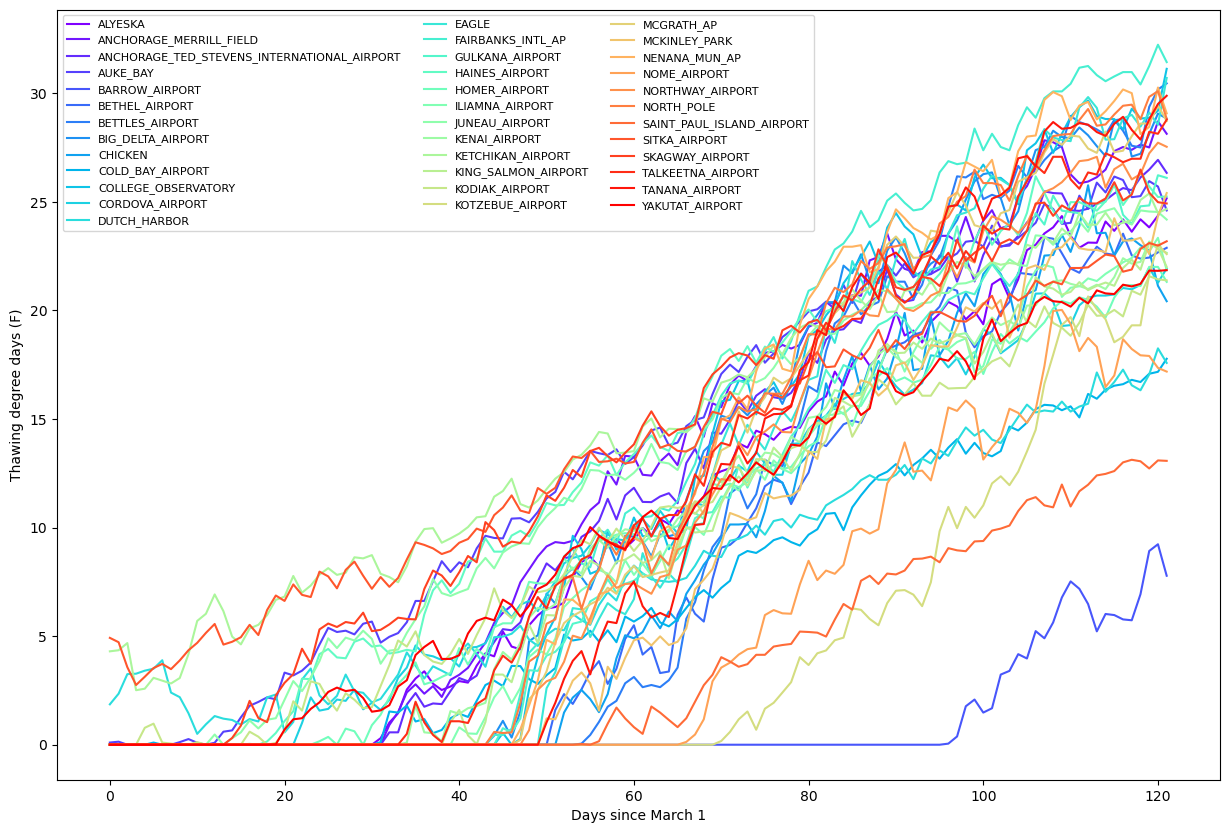

In [372]:
for fp in clims:
    name = fp.stem[:-14]
    testdf = pd.read_csv(fp, header=4, index_col=0)
    try:
        aggdf[name] = testdf['tdd']
    except (NameError, TypeError):
        aggdf = pd.DataFrame(testdf['tdd'])
        aggdf.columns = [name]

colors = plt.cm.rainbow(np.linspace(0, 1, len(aggdf.columns)))

fig, ax = plt.subplots(figsize=(15, 10))
aggdf.plot(ax=ax, legend=False, color=colors)
ax.legend(fontsize=8, ncol=3, loc='upper left')
ax.set_xlabel('Days since March 1')
ax.set_ylabel('Thawing degree days (F)')

In [373]:
testdf

,Tavg_F,tdd
d_since_march1,,
0,30.87,0.00
1,29.60,0.00
2,28.48,0.00
3,27.95,0.00
4,28.52,0.00
5,28.62,0.00
6,29.12,0.00
7,29.87,0.00
8,29.85,0.00


### Make tdd and cumul tdd datasets

In [377]:
outpath, datapath

(PosixPath('/Users/chris/Projects/2023_Riverice/data/weatherstations/ACIS/TDD'),
 PosixPath('/Users/chris/Projects/2023_Riverice/data/weatherstations/ACIS/stationdata/low_missing'))

In [417]:
datasuffix = "_T_max_min_avg_sd_swe.csv"
outdir_clim = outpath / "tdd_climatologies"
clims = sorted(list(outdir_clim.glob("*.csv")))

nmissing = 10

for fp in clims:
    name = fp.stem[:-14]
    stationpth = datapath / f"{name}{datasuffix}"
    climdf = pd.read_csv(fp, header=4, index_col=0)
    testdf = get_MAMJ_tdd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > nmissing]
    missing_years = sorted(list(significant_missing.index))
    print(name, missing_years)
    testdf = testdf[~testdf.year.isin(missing_years)]
    testdf['d_since_march1'] = list(testdf.index.to_series().apply(days_past_march1))
    testdf['Tavg_clim'] = testdf.d_since_march1.apply(lambda x: climdf.iloc[x]['Tavg_F'])
    testdf = testdf.replace(-9999, np.nan)
    testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
    testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)
    testdf = testdf[['Tavg_F', 'year']]
    # make string for metadata for missing years
    if missing_years:
        missingstr = f"# Excluded years (more than {str(nmissing)} days of missing data): {', '.join(map(str, missing_years))}\n"
    else:
        missingstr = f"# No years excluded (all years had {str(nmissing)} or fewer days of missing data)\n"
    # write TDD files
    outdf = get_pivotdf(get_tdddf(testdf), value='tdd')
    with open(outpath / f"tdd_bystation/{name}_yearly_TDD.csv", 'w') as dst:
        dst.write(f"# {name}\n")
        dst.write(f"# Thawing degree days starting March 1 from ACIS, gaps filled from climatology\n")
        dst.write(missingstr)
        dst.write("#\n")
        outdf.to_csv(dst, float_format='%.2f')
    # write cumul tdd files
    outdf = get_pivotdf(get_tdddf(testdf))
    with open(outpath / f"tdd_cumul_bystation/{name}_yearly_TDD_cumul.csv", 'w') as dst:
        dst.write(f"# {name}\n")
        dst.write(f"# Cumulative thawing degree days starting March 1 from ACIS, gaps filled from climatology\n")
        dst.write(missingstr)
        dst.write("#\n")
        outdf.to_csv(dst, float_format='%.2f')

    

ALYESKA [1980, 1981, 1989, 2012]
ANCHORAGE_MERRILL_FIELD [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT []
AUKE_BAY [2016]
BARROW_AIRPORT []
BETHEL_AIRPORT []
BETTLES_AIRPORT []
BIG_DELTA_AIRPORT [1990, 1991, 1992, 1993]
CHICKEN [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
COLD_BAY_AIRPORT []
COLLEGE_OBSERVATORY [2000, 2007]
CORDOVA_AIRPORT []
DUTCH_HARBOR [1980, 1981, 1982, 1983, 1984, 1986, 1987, 1988, 1989, 1990, 2001, 2008, 2009, 2018, 2019, 2021]
EAGLE [1982, 2009, 2022]
FAIRBANKS_INTL_AP []
GULKANA_AIRPORT [1995]
HAINES_AIRPORT [1987, 1991, 1993, 1994, 1995, 1997, 1998]
HOMER_AIRPORT []
ILIAMNA_AIRPORT []
JUNEAU_AIRPORT []
KENAI_AIRPORT []
KETCHIKAN_AIRPORT [1981, 1982, 1985, 1986, 1987, 1988]
KING_SALMON_AIRPORT []
KODIAK_AIRPORT []
KOTZEBUE_AIRPORT [2019]
MCGRATH_AP []
MCKINLEY_PARK []
NENANA_MUN_AP [1980, 1981

In [395]:
climdf

,Tavg_F,tdd
d_since_march1,,
0,0.74,0.00
1,0.41,0.00
2,2.22,0.00
3,1.97,0.00
4,2.47,0.00
5,4.45,0.00
6,4.64,0.00
7,4.84,0.00
8,4.81,0.00


In [412]:
get_pivotdf(get_tdddf(testdf))

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
1,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
2,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
3,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
4,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
5,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
6,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
7,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
8,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00


Text(0, 0.5, 'Cumulative thawing degree days (F)')

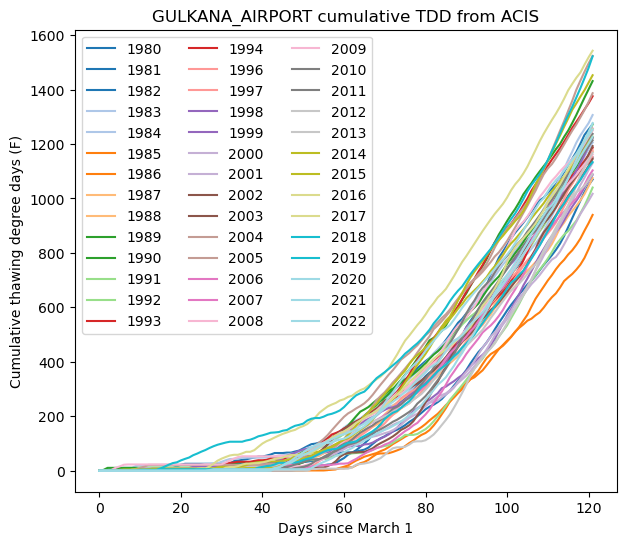

In [432]:
name = "GULKANA_AIRPORT"

plotdf = pd.read_csv(outpath / f"tdd_cumul_bystation/{name}_yearly_TDD_cumul.csv", header=4, index_col=0 )

fig, ax = plt.subplots(figsize=(7, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(plotdf.columns)))
plotdf.plot(color=colors, legend=False, ax=ax, title=f"{name} cumulative TDD from ACIS")
ax.legend(fontsize=10, ncol=3, loc='upper left')
ax.set_xlabel('Days since March 1')
ax.set_ylabel('Cumulative thawing degree days (F)')


## Prototyping area

In [268]:
testdf = station2df(stations[50])
stations[50].stem[:-21], len(stations), testdf

('PORTAGE_GLACIER_VISITOR_CENTER',
 64,
            Tmax_f Tmin_F Tavg_F   sd_m   swe  year
 1980-01-02  -9999  -9999  -9999  -9999 -9999  1980
 1980-01-03  -9999  -9999  -9999  -9999 -9999  1980
 1980-01-04  -9999  -9999  -9999  -9999 -9999  1980
 1980-01-05  -9999  -9999  -9999  -9999 -9999  1980
 1980-01-06  -9999  -9999  -9999  -9999 -9999  1980
 ...           ...    ...    ...    ...   ...   ...
 2023-02-25     30     20   25.0  -9999 -9999  2023
 2023-02-26     25     14   19.5  -9999 -9999  2023
 2023-02-27     15     -5    5.0  -9999 -9999  2023
 2023-02-28     25     -5   10.0  -9999 -9999  2023
 2023-03-01  -9999  -9999  -9999  -9999 -9999  2023
 
 [15765 rows x 6 columns])

In [269]:
testdf = get_MAMJ_tdd(testdf)
testdf

,Tavg_F,year
1980-03-01,-9999,1980
1980-03-02,-9999,1980
1980-03-03,-9999,1980
1980-03-04,-9999,1980
1980-03-05,-9999,1980
...,...,...
2022-06-26,53.5,2022
2022-06-27,54.0,2022
2022-06-28,60.0,2022
2022-06-29,57.0,2022


In [270]:
pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))

,count_missing
year,
1980,122
1981,122
1982,122
1983,122
1984,122
1985,122
1986,95
1987,122
1988,122


In [271]:
testdf = get_tdddf(testdf)


,year,d_since_march1,Tavg_F,tdd,tdd_cumul
0,1980,0,-9999,0.0,0.0
1,1980,1,-9999,0.0,0.0
2,1980,2,-9999,0.0,0.0
3,1980,3,-9999,0.0,0.0
4,1980,4,-9999,0.0,0.0
...,...,...,...,...,...
5241,2022,117,53.5,21.5,1047.0
5242,2022,118,54.0,22.0,1069.0
5243,2022,119,60.0,28.0,1097.0
5244,2022,120,57.0,25.0,1122.0


In [276]:
testdf[(testdf.year > 1990) & (testdf.year < 2021)].replace(-9999, np.nan)

,year,d_since_march1,Tavg_F,tdd,tdd_cumul
1342,1991,0,NaN,0.0,0.0
1343,1991,1,NaN,0.0,0.0
1344,1991,2,NaN,0.0,0.0
1345,1991,3,NaN,0.0,0.0
1346,1991,4,NaN,0.0,0.0
...,...,...,...,...,...
4997,2020,117,49.5,17.5,1100.0
4998,2020,118,52.5,20.5,1120.5
4999,2020,119,51.5,19.5,1140.0
5000,2020,120,50.0,18.0,1158.0


In [319]:
testdf = get_MAMJ_tdd(station2df(stations[1]))
missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
significant_missing = missing[missing.count_missing > 5]
mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
testdf = testdf[(testdf.year > 1990) & (testdf.year < 2021) & (~testdf.year.isin(mising_sig_climatology_years))].replace(-9999, np.nan)
testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
testdf = testdf.interpolate(method='linear', axis=0)
climatology = pd.DataFrame(get_pivotdf(get_tdddf(testdf), value='Tavg_F').mean(axis=1), columns=['Tavg_F'])
climatology['tdd'] = climatology['Tavg_F'] - 32
climatology.loc[climatology['tdd'] < 0, 'tdd'] = 0

<AxesSubplot: xlabel='d_since_march1'>

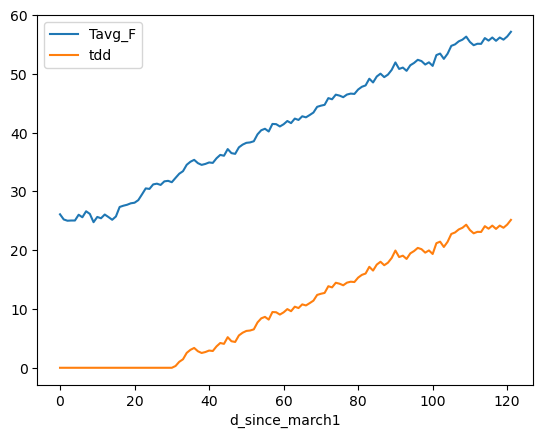

In [320]:
climatology.plot()

In [316]:
climatology

,Tavg_F,tdd
d_since_march1,,
0,25.173913,0.000000
1,24.543478,0.000000
2,24.913043,0.000000
3,24.760870,0.000000
4,25.434783,0.000000
5,26.652174,0.000000
6,25.456522,0.000000
7,26.586957,0.000000
8,26.326087,0.000000


In [286]:
pd.set_option('display.max_rows', 150)

In [289]:
mising_sig_climatology_years

{1991, 1992, 1994, 2003, 2004, 2009, 2012}

In [290]:
significant_missing

,count_missing
year,
1980,102
1981,42
1982,36
1983,23
1984,14
1989,35
1991,6
1992,9
1994,6
